In [113]:
import pandas as pd
import numpy as np
import lightgbm
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import shap

In [114]:
warnings.filterwarnings('ignore')

In [115]:
train_df_final = pd.read_csv('./input/processed/train_df_final_v5.csv')
test_df_final = pd.read_csv('./input/processed/test_df_final_v5.csv')

In [116]:
train_df_final.head()

,id,climatology_temp,target,elev,doy_sin,doy_cos,day_length,dew_point_avg,humidity_avg,dew_humidity_interaction,...,humidity_avg_x_dew_depression_morning_sq,humidity_avg_x_dew_depression_evening_sq,dp_evening_avg_sq,dew_depression_night_sq,wind_speed_avg_sq,wind_speed_avg_X_slp_avg,wind_speed_avg_X_STA,ratio_STA_x_slp_div_slp_avg,ratio_STA_x_slp_div_humidity_avg,ratio_STA_x_slp_div_elev
0,0,-2.707143,-3.992857,115.62,0.017213,0.999852,9.426812,-16.808333,46.875000,-787.890625,...,180625.000000,283889.160156,295.266944,93.444444,2.904184,1762.811302,-5070.181078,-2.876190,-63.470236,-25.732290
1,1,-3.646429,-1.653571,115.62,0.034422,0.999407,9.437325,-17.466667,45.500000,-794.733333,...,138074.173611,247473.084444,290.134444,64.000000,0.926406,996.323854,-2108.292441,-2.116071,-48.141399,-18.945111
2,2,-2.694643,-0.005357,115.62,0.051620,0.998667,9.448699,-17.645833,43.583333,-769.064236,...,113109.834493,325974.386736,344.102500,54.022500,0.708403,872.005243,-2290.051865,-2.626190,-62.428764,-23.532725
3,3,-2.501786,-0.898214,115.62,0.068802,0.997630,9.460926,-11.966667,53.166667,-636.227778,...,188524.815586,14953.213611,31.360000,75.690000,1.050625,1057.577917,-1500.753425,-1.419048,-27.538865,-12.663464
4,4,-2.625000,-1.775000,115.62,0.085965,0.996298,9.473997,-15.729167,40.583333,-638.342014,...,128027.797317,333663.476860,402.671111,8.027778,2.042517,1469.076146,-1126.291712,-0.766667,-19.418706,-6.816086


# Dataset Splitting

In [117]:
features = [col for col in train_df_final.columns if col not in ['id', 'target']]

X = train_df_final[features].values
y = train_df_final['target'].values
X_test = test_df_final[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Optuna Setup

In [118]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 512),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': 52
    }
    model = lightgbm.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            lightgbm.early_stopping(stopping_rounds=100, verbose=False),
            lightgbm.log_evaluation(period=0)
        ]
    )
    preds = model.predict(X_val)
    return root_mean_squared_error(y_val, preds)

In [119]:
# study = optuna.create_study(direction='minimize', study_name='lgbm_reg_opt')
# study.optimize(objective, n_trials=30, n_jobs=10)
# print("Best trial:")
# print(f"  RMSE: {study.best_value:.5f}")
# print(f"  Params: {study.best_params}")

# 4) Retrain final model with best params
# best_params = study.best_params.copy()
# best_params.update({
#     'objective': 'regression',
#     'metric': 'rmse',
#     'boosting_type': 'gbdt',
#     'verbosity': -1,
#     'random_state': 52
# })

In [120]:
best_params = {'n_estimators': 6745, 'learning_rate': 0.06522862721033737, 'num_leaves': 388, 'max_depth': 5, 'subsample': 0.8466848255564012, 'colsample_bytree': 0.7841450269172936, 'min_child_weight': 1.742148924703299, 'reg_alpha': 7.56560286836146e-06, 'reg_lambda': 7.075276103206667, 'verbosity': -1}

# Fit

In [121]:
lgbm = lightgbm.LGBMRegressor(**best_params)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[lightgbm.log_evaluation(period=0),
               lightgbm.early_stopping(stopping_rounds=100, verbose=False)],
)

y_pred = lgbm.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"\n✅ LightGBM R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ LightGBM R²: 0.8251 | RMSE: 1.2522


# Feature Importance

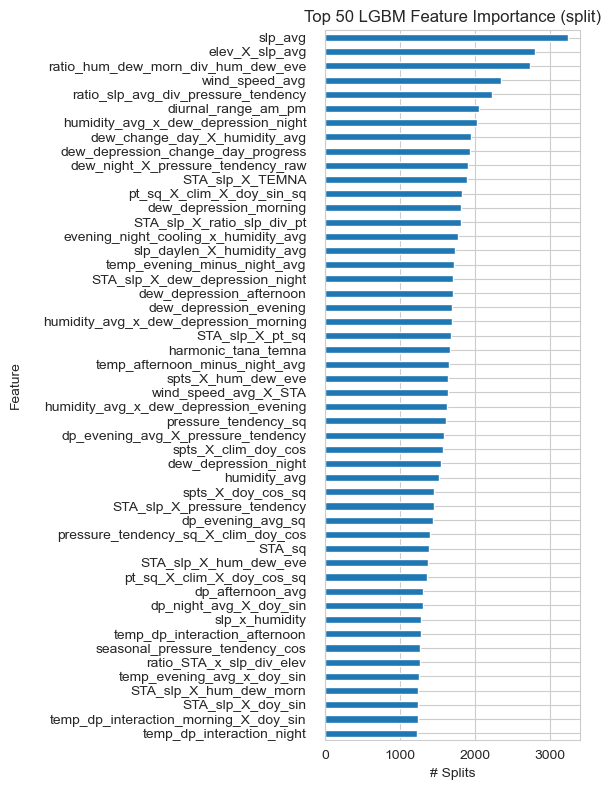

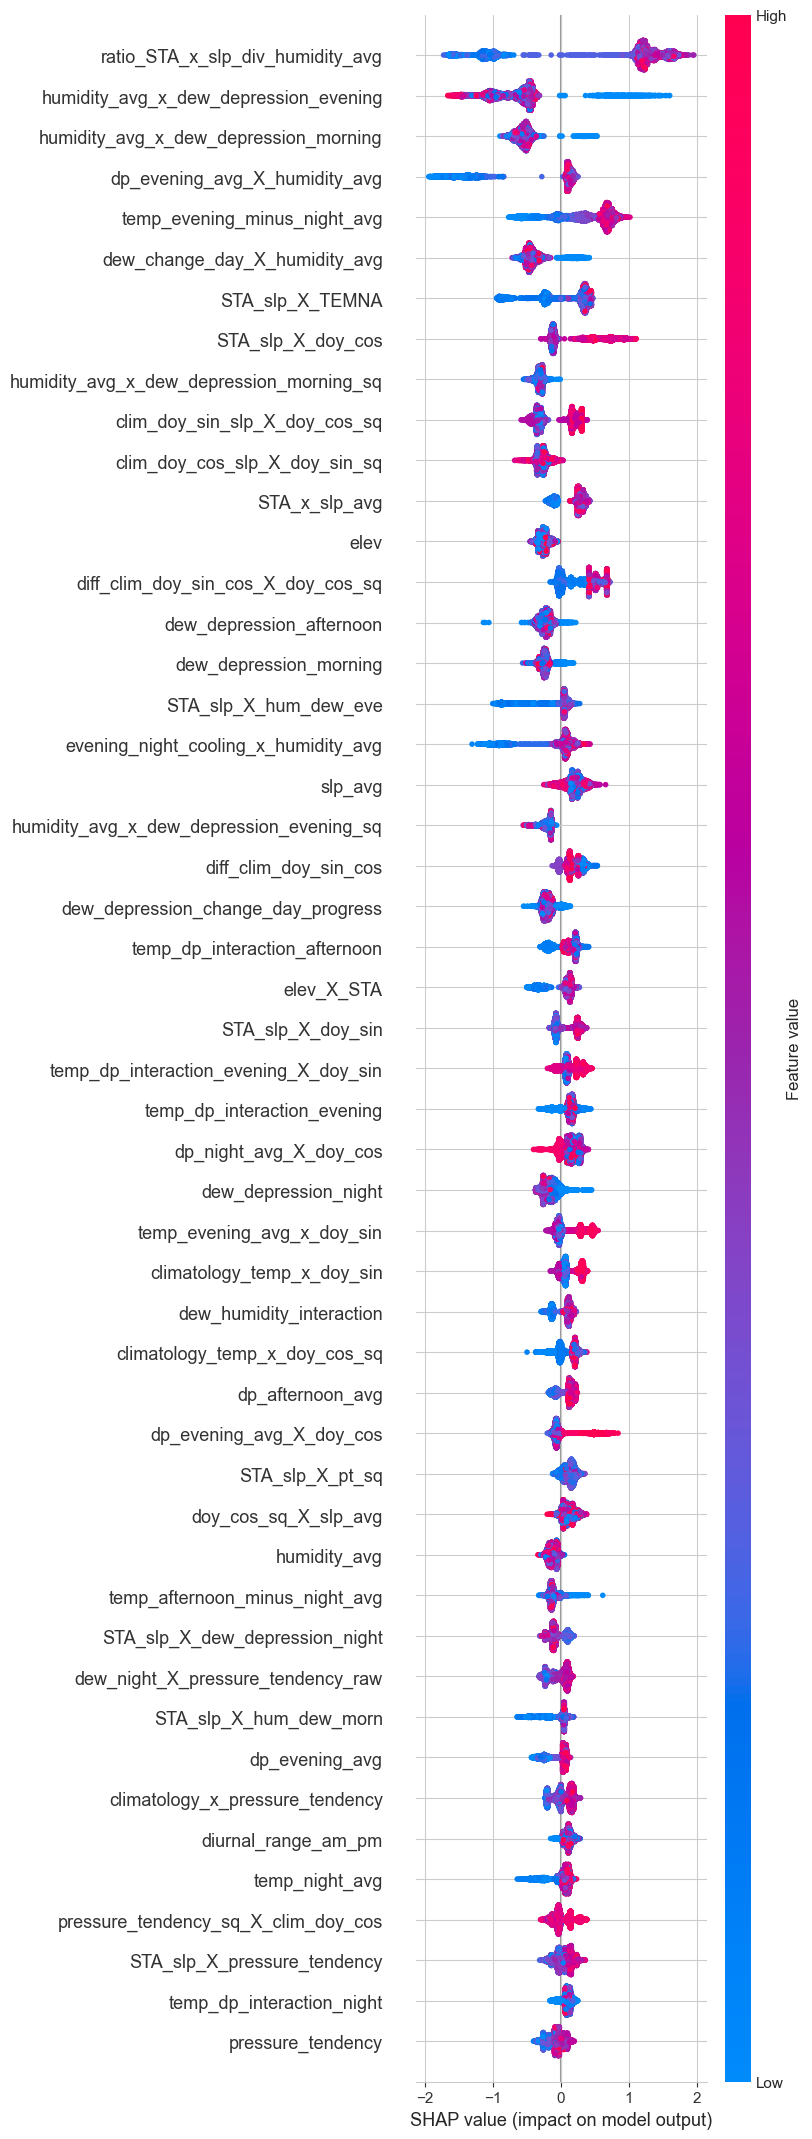

In [122]:
imp_split = lgbm.feature_importances_

feat_imp_split = pd.Series(imp_split, index=features).sort_values(ascending=False)

top_N = 50

# 1) Plot split importances
fig, ax = plt.subplots(figsize=(6, 8))
feat_imp_split.head(top_N).plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set_title(f'Top {top_N} LGBM Feature Importance (split)')
ax.set_xlabel('# Splits')
ax.set_ylabel('Feature', labelpad=15)
ax.tick_params(axis='y', pad=10)
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()

# 2) SHAP Summary Plots
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=top_N, feature_names=features)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feat_shap_imp = pd.Series(mean_abs_shap, index=features).sort_values(ascending=False)

In [123]:
print(f"Top {top_N} LGBM Importances (split):")
print(feat_imp_split.head(top_N).to_string())
print("="*50)
print("Top SHAP Feature Importances (mean |SHAP value|):")
print(feat_shap_imp.head(top_N).to_string())

Top 50 LGBM Importances (split):
slp_avg                                  3236
elev_X_slp_avg                           2801
ratio_hum_dew_morn_div_hum_dew_eve       2728
wind_speed_avg                           2350
ratio_slp_avg_div_pressure_tendency      2230
diurnal_range_am_pm                      2050
humidity_avg_x_dew_depression_night      2018
dew_change_day_X_humidity_avg            1944
dew_depression_change_day_progress       1926
dew_night_X_pressure_tendency_raw        1897
STA_slp_X_TEMNA                          1891
pt_sq_X_clim_X_doy_sin_sq                1821
dew_depression_morning                   1812
STA_slp_X_ratio_slp_div_pt               1807
evening_night_cooling_x_humidity_avg     1775
slp_daylen_X_humidity_avg                1732
temp_evening_minus_night_avg             1721
STA_slp_X_dew_depression_night           1705
dew_depression_afternoon                 1698
dew_depression_evening                   1696
humidity_avg_x_dew_depression_morning    1685
S

# Feature Selection with SHAP

In [124]:
print("Lowest SHAP Importances:")
print(feat_shap_imp.tail(50).to_string())

Lowest SHAP Importances:
wind_speed_avg                           0.086477
climatology_temp                         0.086339
spts_X_doy_cos_sq                        0.085928
elev_X_slp_avg                           0.085643
clim_doy_cos_X_slp_avg_base              0.085075
temp_dp_interaction_evening_X_doy_cos    0.084260
seasonal_pressure_tendency_cos           0.081915
temp_evening_avg                         0.080323
dp_morning_avg                           0.078330
clim_doy_sin_slp_X_doy_cos               0.077716
dp_evening_avg_X_pressure_tendency       0.077662
dp_night_avg_X_doy_sin                   0.077286
wind_speed_avg_X_STA                     0.077239
seasonal_pressure_tendency_sin           0.076238
climatology_temp_x_doy_cos               0.075790
slp_x_humidity                           0.072915
temp_morning_avg                         0.070599
climatology_temp_x_doy_sin_sq            0.067746
ratio_slp_avg_div_pressure_tendency      0.066617
spts_X_hum_dew_eve       

In [125]:
print(feat_imp_split.to_string())

slp_avg                                     3236
elev_X_slp_avg                              2801
ratio_hum_dew_morn_div_hum_dew_eve          2728
wind_speed_avg                              2350
ratio_slp_avg_div_pressure_tendency         2230
diurnal_range_am_pm                         2050
humidity_avg_x_dew_depression_night         2018
dew_change_day_X_humidity_avg               1944
dew_depression_change_day_progress          1926
dew_night_X_pressure_tendency_raw           1897
STA_slp_X_TEMNA                             1891
pt_sq_X_clim_X_doy_sin_sq                   1821
dew_depression_morning                      1812
STA_slp_X_ratio_slp_div_pt                  1807
evening_night_cooling_x_humidity_avg        1775
slp_daylen_X_humidity_avg                   1732
temp_evening_minus_night_avg                1721
STA_slp_X_dew_depression_night              1705
dew_depression_afternoon                    1698
dew_depression_evening                      1696
humidity_avg_x_dew_d

# Predict with Test Dataset

In [126]:
# y_test_pred = lgbm.predict(X_test_scaled)
#
# submission = pd.DataFrame({
#     "id": test_df_final["id"],
#     "target": y_test_pred
# })
#
# now = datetime.now().strftime("%Y%m%d_%H%M%S")
#
# submission.to_csv(f'./output/submission_{now}.csv', index=False)